# Setup Spark on Colab Environment

In [ ]:
!pip install pyspark==3.1.2
!apt-get update
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.4 MB 82 kB/s 
     |████████████████████████████████| 198 kB 71.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=01c1982d4c9d018feadb899eeec8b79c7eee7e384aaf4e400a0a7f1dd7501766
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Get:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB

In [ ]:
import pyspark
pyspark.__version__

'3.1.2'

In [ ]:
!unzip -q ml-latest-small.zip -d ./

# Recommendation System: Item-item Collaborative Filtering

In [ ]:
import pyspark
from pyspark import SparkConf, SparkContext

from operator import add

import math

Create a Spark context.

In [ ]:
conf = SparkConf().set("spark.ui.port", "4050")
sc = SparkContext(conf = conf)

When reading the ratings data, to deal with the first row of string (names of attributes), we use the flatMap function and design our mapper to return a list.
- For the line of attribute names, we return an empty list.
- Otherwise, we return a list containing one key-value pair.

When we flatten the result coming from the mapper, the empty list is automatically removed.

In [ ]:
def read_ratings_data(line):
    '''
    Input: a string of 'user_id,movie_id,rating,timestamp'
    Output: a key-value pair of (movie_id, (user_id, rating))
    '''
    elements = line.split(',')
    if elements[0] == 'userId':
        return []
    return [(int(elements[1]), (int(elements[0]), float(elements[2])))]

In [ ]:
# original_data = sc.textFile('./toydata.csv').flatMap(read_ratings_data)
original_data = sc.textFile('./ml-latest-small/ratings.csv').flatMap(read_ratings_data)

## Subtract mean rating from each movie

Calculate average ratings:
1. Map (movie_id, (user_id, rating)) to (movie_id, (1, rating))
2. Reduce by key to produce one (movie_id, (#ratings, sum_of_ratings)) for each movie.
3. Map (movie_id, (#ratings, sum_of_ratings)) to (movie_id, avg_ratings), where avg_ratings = sum_of_ratings / #ratings.

In [ ]:
avg_ratings = original_data \
        .map(lambda x: (x[0], (1, x[1][1]))) \
        .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
        .map(lambda x: (x[0], x[1][1] / x[1][0]))

In [ ]:
subtract_mean_data = original_data \
            .join(avg_ratings) \
            .map(lambda x: (x[0], [(x[1][0][0], x[1][0][1] - x[1][1])])) \
            .reduceByKey(lambda x, y: x + y)

## Calculate norm of each item's rating vector

In [ ]:
def calculate_norm(ratings):
    squared_sum = sum([user_rating ** 2 for (user_id, user_rating) in ratings[1]])
    return (ratings[0], math.sqrt(squared_sum))   # (movie_id, norm_of_rating_vector)

In [ ]:
norms = subtract_mean_data.map(calculate_norm)

## Calculate dot product of two rating vectors

Since the rating vector for each movie may be sparse (many missing values), it may be more convenient to calculate the dot product by fisrt computing the pairwise multiplication of movies' ratings within each user id and then aggregating the values along user-id dimension.

Three steps:
1. Convert row data (movie_id, [(user_id, rating), ...]) into column data (user_id, [(movie_id, rating), ...]).
2. For each user id, generate pairs of ((movie_id_1, movie_id_2), rating_product), where movie_id_1 < movie_id_2.
3. Aggregate those values along user-id dimension to obtain dot product of two movies' ratings.

In [ ]:
def convert_to_user_id_key(row_data):
    '''
    Input: (movie_id, [(user_id, rating), ...])
    Output: a list of (user_id, [(movie_id, rating)])
    '''
    movie_id = row_data[0]
    output = [(user_id, [(movie_id, rating)]) for (user_id, rating) in row_data[1]]
    return output

In [ ]:
column_data = subtract_mean_data.flatMap(convert_to_user_id_key).reduceByKey(lambda x, y: x + y)

In [ ]:
def generate_movie_pairs(column_data):
    '''
    Input: (user_id, [(movie_id_1, rating_1), (movie_id_2, rating_2), ...])
    Output: [((movie_id_1, movie_id_2), rating_1 * rating_2), ...]
    '''
    output = [
        ((movie_id_1, movie_id_2), rating_1 * rating_2) \
        for (movie_id_1, rating_1) in column_data[1] \
        for (movie_id_2, rating_2) in column_data[1] \
        if movie_id_1 < movie_id_2
    ]
    return output

In [ ]:
dot_products = column_data.flatMap(generate_movie_pairs).reduceByKey(lambda rating_1, rating_2: rating_1 + rating_2)

## Cosine Similarity

Dot product = 0 will produce 0 cosine similarity, so we can filter it out first.

In [ ]:
dot_products = dot_products.filter(lambda data: data[1] != 0)

((movie_id_1, movie_id_2), dot_product) = pair, ...... \
→ (movie_id_1, pair), (movie_id_2, pair), ...... \
→ (movie_id_1, (pair, norm_1)), (movie_id_2, (pair, norm_2)), ...... \
→ (pair, norm_1), (pair, norm_2), ...... \
→ (pair, norm_1 * norm_2), ...... \
→ ((movie_id_1, movie_id_2), dot_product / (norm_1 * norm_2)), ......

In [ ]:
cosine_similarity = dot_products \
           .flatMap(lambda pair: [(pair[0][0], pair), (pair[0][1], pair)]) \
           .join(norms) \
           .map(lambda pair: (pair[1][0], pair[1][1])) \
           .reduceByKey(lambda norm1, norm2: norm1 * norm2) \
           .map(lambda pair: (pair[0][0], pair[0][1] / pair[1]))

Output cosine similarities

In [ ]:
cosine_similarity_list = cosine_similarity.sortBy(lambda x: (x[0][0], x[0][1])).collect()

In [ ]:
movieID_UniversalSet_list = original_data \
            .map(lambda x: x[0]) \
            .distinct() \
            .sortBy(lambda x: x) \
            .collect()
numMovie = len(movieID_UniversalSet_list)


idx_i = 0
idx_j = 1
def fill_zero_similarities(idx_i, idx_j, targetID1, targetID2, fh):
    while movieID_UniversalSet_list[idx_i] < targetID1 or \
          movieID_UniversalSet_list[idx_j] < targetID2:
        fh.write(f'({movieID_UniversalSet_list[idx_i]:d}, {movieID_UniversalSet_list[idx_j]:d}): {0.0:f}\n')
        idx_j += 1
        if idx_j >= numMovie:
            idx_i += 1
            idx_j = idx_i + 1
            if idx_i == numMovie-1:
                break
    return idx_i, idx_j

In [ ]:
with open('./cosine_similarity.txt', 'w') as fh:

    for data in cosine_similarity_list:
        movieID1 = data[0][0]
        movieID2 = data[0][1]
        sim = data[1]
    
        idx_i, idx_j = fill_zero_similarities(idx_i, idx_j, movieID1, movieID2, fh)
        fh.write(f'({movieID1:d}, {movieID2:d}): {sim:f}\n')
        idx_j += 1
        if idx_j >= numMovie:
            idx_i += 1
            idx_j = idx_i + 1
    
    idx_i, idx_j = fill_zero_similarities(idx_i, idx_j, movieID_UniversalSet_list[-1], movieID_UniversalSet_list[-1], fh)

# for data in cosine_similarity_list:
#     print(f'({data[0][0]:d}, {data[0][1]:d}): {data[1]:f}')


In [ ]:
del cosine_similarity_list

## Predictions (Advanced Section)

For each movie id, find its pre-computed cosine similarity with other moives:

((movie_id_1, movie_id_2), cosine_similarity), ...... \
→ (movie_id_1, [(movie_id_2, cosine_similarity)]), (movie_id_2, [(movie_id_1, cosine_similarity)]), ...... \
→ (movie_id_1, [(movie_id_2, cosine_similarity), ...]), (movie_id_2, [(movie_id_1, cosine_similarity), ...]), ...... \
→ For each movie_id, sort its correponding list in the descending order of (sign(sim), abs(sim)).

Why do we sort in this way? \
- Motivation: Negative similarity may cause the prediction to produce values outside the range [0, 5], which is undefined. However, if we only use positive similarity for prediction, the number of slots that we can predict will certainly decrease. So, we design the following method to deal with this issue.
- For positive correlated movies, they can contribute to the prediction via $similarity \times rating$.
- For highly negative correlated movies, they can contribute to the prediction via inversion: $|\:similarity\:| \times (5 - rating)$.
- Our priority becomes "positive similarity > negative similarity with large absolute value > negative similarity with small absolute value."

In [ ]:
def sort_movie_similarities(movie_sim_pair):
    movie_id = movie_sim_pair[0]
    # sort (movie_id, cosine_sim) pairs in descending order of (sign(cosine_sim), abs(cosine_sim))
    sorted_sims = sorted(movie_sim_pair[1], key = lambda pair: (int(pair[1] > 0), abs(pair[1])), reverse = True)
    
    return (movie_id, sorted_sims)

In [ ]:
movie_similarites = cosine_similarity \
           .flatMap(lambda pair: [(pair[0][0], [(pair[0][1], pair[1])]), (pair[0][1], [(pair[0][0], pair[1])])]) \
           .reduceByKey(add) \
           .map(sort_movie_similarities)

Construct a hash table of movie similarities for faster look-up in the later stage:

[(movie_id_1, [(movie_id_2, cosine_similarity), ...]), ...] \
→ { movie_id_1: [(movie_id_2, cosine_similarity), ...], ... }

In [ ]:
movie_similarites_dict = dict(movie_similarites.collect())

Also, get a list of rated movies for each user id, i.e., the column data (user_id, [(movie_id_1, rating_1), ...]).

In [ ]:
# Recall that "original_data" contains list of (movie_id, (user_id, rating)) pairs
# Convert into (user_id, [(movie_id_1, rating_1), ...])
user_movie_ratings = original_data.map(lambda pair: (pair[1][0], [(pair[0], pair[1][1])])).reduceByKey(add)

In [ ]:
all_movie_ids_list = original_data.map(lambda pair: pair[0]).distinct().collect()

Select top 10 similarity to calculate the movie rating for each user.

$r_{xi} = \dfrac{\sum_{j \in N(i;x)} |\;s_{ij}\;| \cdot r_{xj}^{\prime}}{\sum_{j \in N(i;x)} |\;s_{ij}\;|}$

- If $s_{ij} \geq 0$, $\;\; r_{xj}^{\prime} = r_{xj}$.
- Otherwise, $\;\; r_{xj}^{\prime} = 5 - r_{xj}$. (use inverted rating for negative correlated movies)

In [ ]:
def predict(column_data):
    '''
    Input: column data = (user_id, [(movie_id_1, rating_1), ...])
    Output: [((user_id, missing_movie_id), predicted_rating), ...]

    Assume "movie_similarites_dict" and "all_movie_ids_list" are pre-computed.
    '''
    existing_movie_ratings = dict(column_data[1])   # hash table for faster checking
    missing_movie_ids = filter(lambda id: id not in existing_movie_ratings, all_movie_ids_list)

    predictions = []

    for id in missing_movie_ids:
        weighted_rating = 0
        sum_of_similarites = 0
        cnt = 0

        if id not in movie_similarites_dict:
            continue
        
        # Criterion 1: Use movies with higher similarity to the target one
        similar_movies = movie_similarites_dict[id]

        for (movie_id, sim) in similar_movies:
            # Criterion 2: This similar movie has been rated by the user
            if movie_id in existing_movie_ratings:
                if sim >= 0:
                    rating = existing_movie_ratings[movie_id]
                else:
                    rating = 5 - existing_movie_ratings[movie_id]
                
                weighted_rating = weighted_rating + abs(sim) * rating
                sum_of_similarites = sum_of_similarites + abs(sim)

                cnt += 1
            if cnt >= 10: break
        
        if sum_of_similarites != 0:   # avoid zero division when criterion 1&2 are disjoint
            predictions.append(((column_data[0], id), weighted_rating / sum_of_similarites))
    
    return predictions

In [ ]:
predictions = user_movie_ratings.flatMap(lambda column_data: predict(column_data))

In [ ]:
predictions_list = predictions.sortByKey().collect()

In [ ]:
with open('./predictions.txt', 'w') as fh:
    for data in predictions_list:
        fh.write(f'({data[0][0]:d}, {data[0][1]:d}): {data[1]:f}\n')

# for data in predictions_list:
#     print(f'({data[0][0]:d}, {data[0][1]:d}): {data[1]:f}')


### Predictions with positive similarity only

In [ ]:
def predict_positive(column_data):
    '''
    Input: column data = (user_id, [(movie_id_1, rating_1), ...])
    Output: [((user_id, missing_movie_id), predicted_rating), ...]

    Assume "movie_similarites_dict" and "all_movie_ids_list" are pre-computed.
    '''
    existing_movie_ratings = dict(column_data[1])   # hash table for faster checking
    missing_movie_ids = filter(lambda id: id not in existing_movie_ratings, all_movie_ids_list)

    predictions = []

    for id in missing_movie_ids:
        weighted_rating = 0
        sum_of_similarites = 0
        cnt = 0

        if id not in movie_similarites_dict:
            continue
        
        # Criterion 1: Use movies with higher similarity to the target one
        similar_movies = movie_similarites_dict[id]

        for (movie_id, sim) in similar_movies:
            if sim < 0:
                continue
            # Criterion 2: This similar movie has been rated by the user
            if movie_id in existing_movie_ratings:
                rating = existing_movie_ratings[movie_id]
            
                weighted_rating = weighted_rating + sim * rating
                sum_of_similarites = sum_of_similarites + sim

                cnt += 1
            if cnt >= 10: break
        
        if sum_of_similarites != 0:   # avoid zero division when criterion 1&2 are disjoint
            predictions.append(((column_data[0], id), weighted_rating / sum_of_similarites))
    
    return predictions

In [ ]:
predictions_positive = user_movie_ratings.flatMap(lambda column_data: predict_positive(column_data))

In [ ]:
predictions_positive_list = predictions_positive.sortByKey().collect()

In [ ]:
with open('./predictions_positive.txt', 'w') as fh:
    for data in predictions_positive_list:
        fh.write(f'({data[0][0]:d}, {data[0][1]:d}): {data[1]:f}\n')

# for data in predictions_positive_list:
#     print(f'({data[0][0]:d}, {data[0][1]:d}): {data[1]:f}')


In [ ]:
# sc.stop()

## Another approach to predicting ratings: mergesort-based

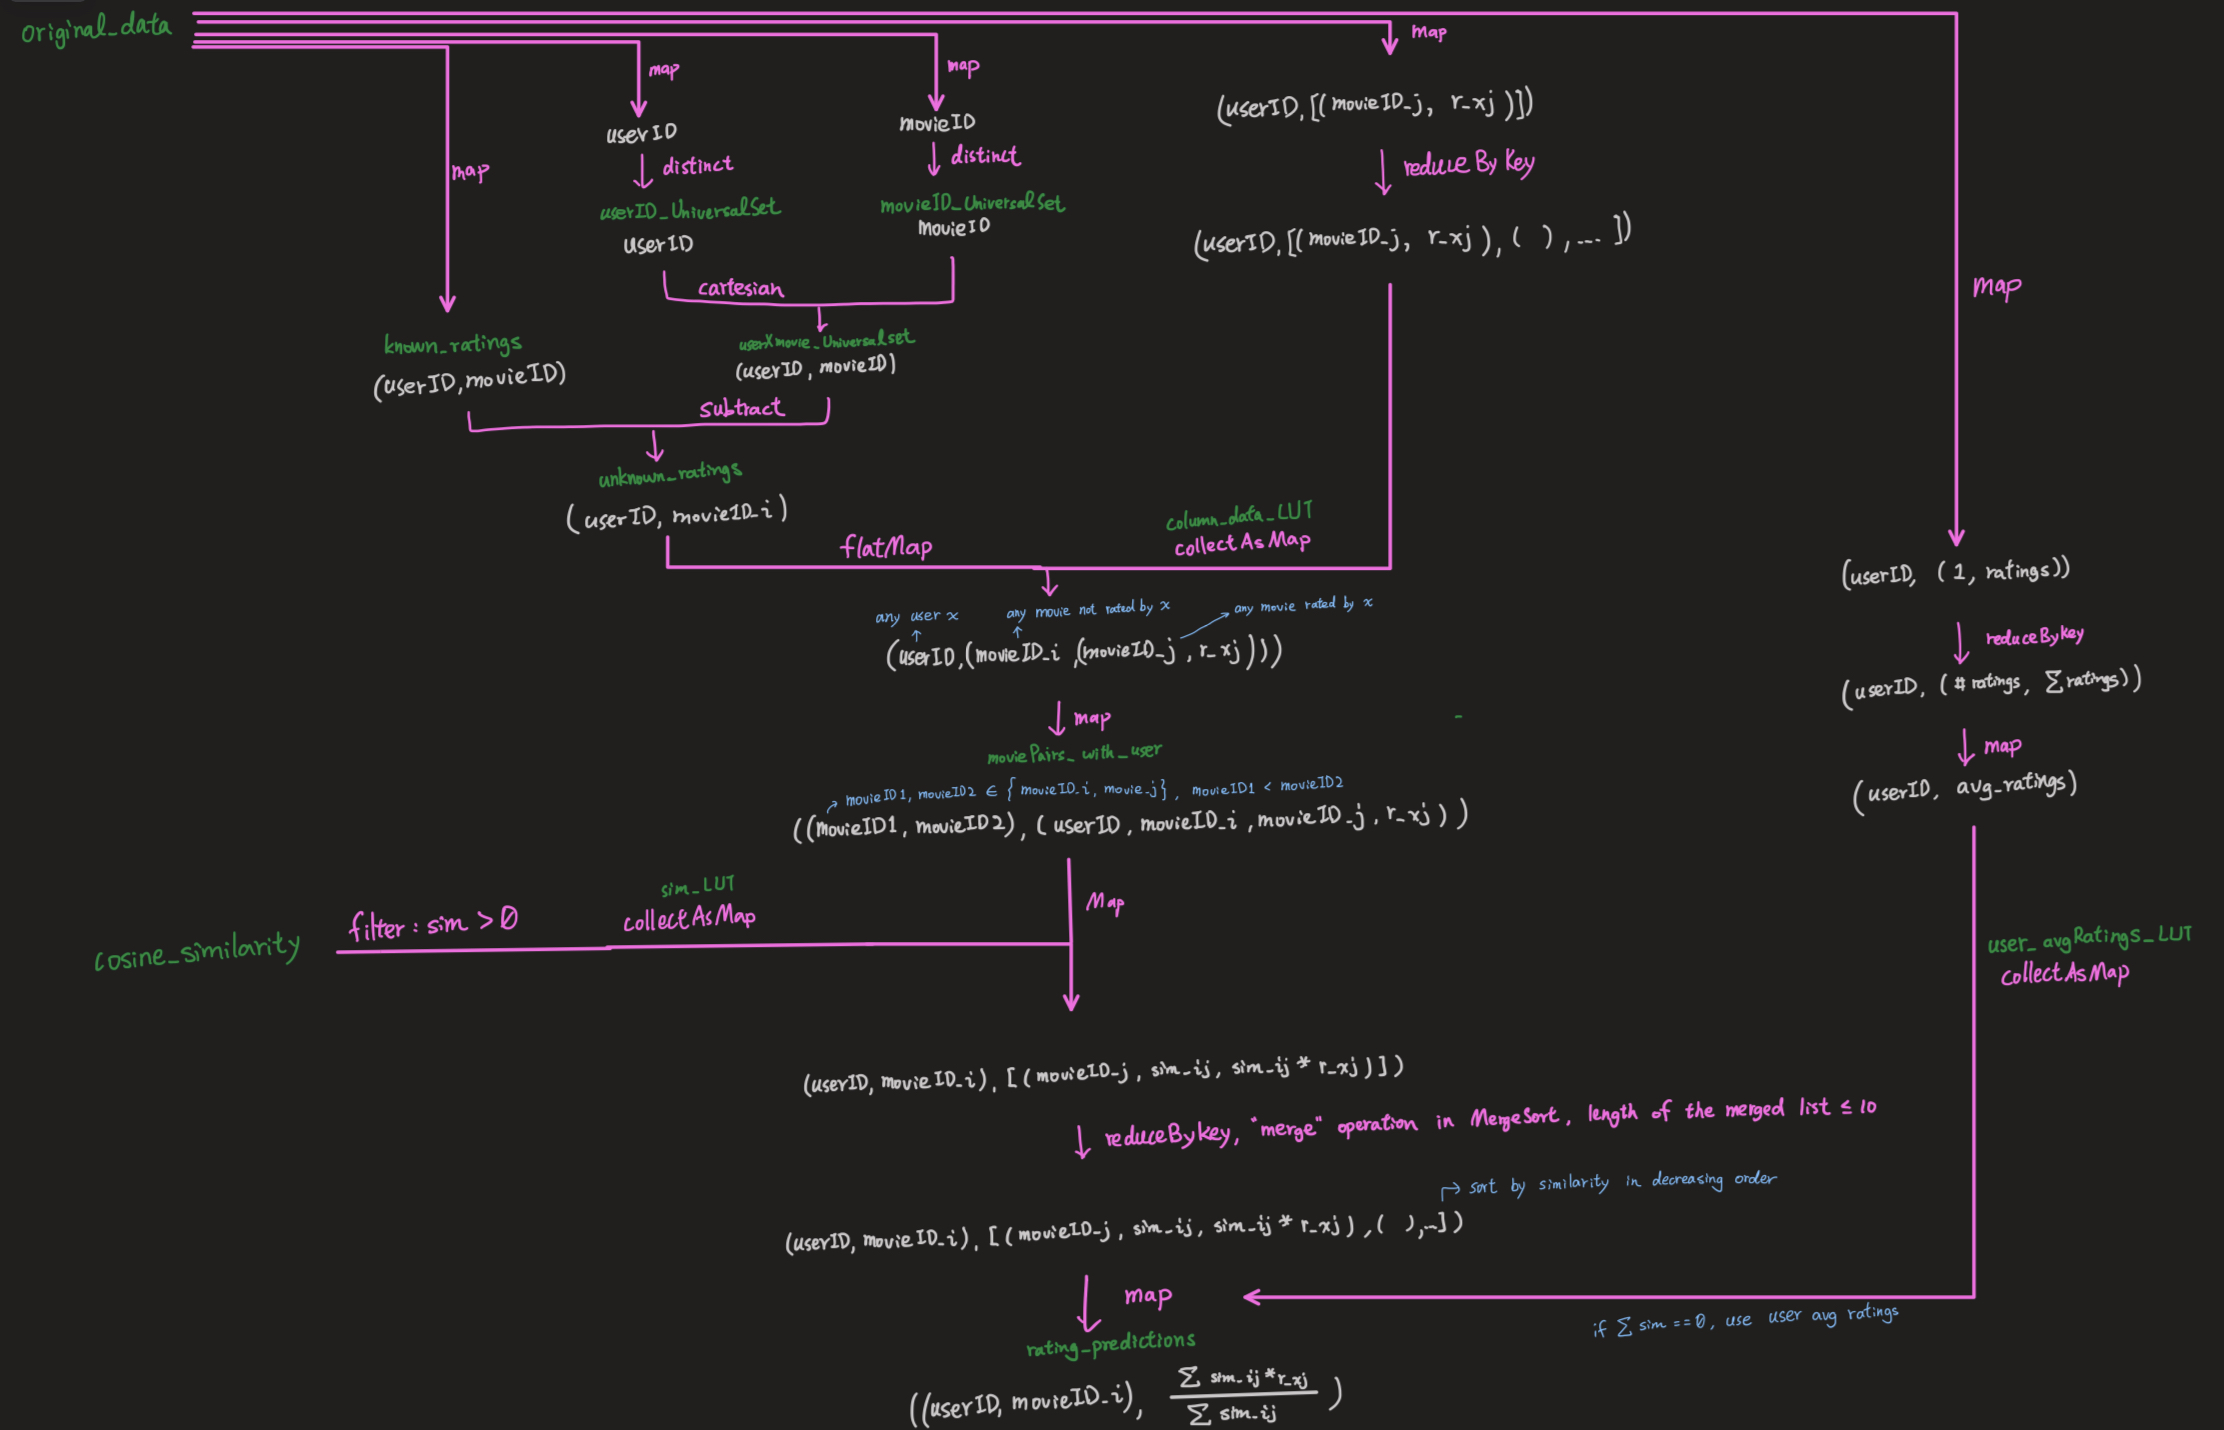

In [ ]:
userID_UniversalSet = original_data \
            .map(lambda x: x[1][0]) \
            .distinct()

movieID_UniversalSet = original_data \
            .map(lambda x: x[0]) \
            .distinct()

userXmovie_UniversalSet = userID_UniversalSet \
            .cartesian(movieID_UniversalSet)

known_ratings = original_data \
            .map(lambda x: (x[1][0], x[0]))

unknown_ratings = userXmovie_UniversalSet \
            .subtract(known_ratings) \
            .repartition(8)

In [ ]:
column_data_LUT = original_data \
            .map(lambda x: (x[1][0], [(x[0], x[1][1])])) \
            .reduceByKey(lambda a, b: a+b) \
            .collectAsMap()

In [ ]:
def gen_moviePairs(data):
    '''
    Input: (userID, movieID_i)
    Output: (userID, (movieID_i, (movieID_j, r_xj)))   
            where for any userID x, movieID_i = any movie not rated by x, movieID_j = any movie rated by x
    '''
    userID = data[0]
    movieID_i = data[1]
    movieID_j_list = column_data_LUT[userID]
    output = [ (userID, (movieID_i, (movieID_j, r_xj)))
                for (movieID_j, r_xj) in movieID_j_list ]
    return output

def add_moviePairs_key(data):
    '''
    Input: (userID, (movieID_i,(movieID_j, r_xj)))
    Output: ((movieID1, movieID2), (userID, movieID_i, movieID_j, r_xj)),
            where movieID1 = min{movieID_i, movieID_j}, movieID2 = max{movieID_i, movieID_j} 
    '''
    userID = data[0]
    movieID_i = data[1][0]
    movieID_j = data[1][1][0]
    r_xj = data[1][1][1]

    if movieID_i < movieID_j:
        return ((movieID_i, movieID_j), (userID, movieID_i, movieID_j, r_xj))
    else:
        return ((movieID_j, movieID_i), (userID, movieID_i, movieID_j, r_xj))


moviePairs_with_user = unknown_ratings \
            .flatMap(gen_moviePairs) \
            .map(add_moviePairs_key) \
            .repartition(8)

In [ ]:
sim_LUT = cosine_similarity \
            .filter(lambda data: data[1] > 0) \
            .collectAsMap()

user_avgRatings_LUT = original_data \
            .map(lambda x: (x[1][0], (1, x[1][1]))) \
            .reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1])) \
            .map(lambda x: (x[0], x[1][1]/x[1][0])) \
            .collectAsMap()

In [ ]:
def add_sim_info(data):
    '''
    Input: ((movieID1, movieID2), (userID, movieID_i, movieID_j, r_xj))
    Output: ((userID, movieID_i), [(movieID_j, sim_ij, sim_ij*r_xj)])
    '''
    sim_ij = sim_LUT.get(data[0], 0.0) # if key does not exist, set to 0.0
    userID = data[1][0]
    movieID_i = data[1][1]
    movieID_j = data[1][2]
    r_xj = data[1][3]
    return ((userID, movieID_i), [(movieID_j, sim_ij, sim_ij*r_xj)]) 

def merge_and_sort(listA, listB):
    '''
    `merge` operation in MergeSort, merge lists with the form [(movieID_j, sim_ij, sim_ij*r_xj), (), ...],
    sort by sim_ij in decreasing order
    '''
    listRet = list()
    idxA = idxB = 0
    lenA = len(listA)
    lenB = len(listB)

    while idxA < lenA and idxB < lenB:
        if listA[idxA][1] > listB[idxB][1]:
            listRet.append(listA[idxA])
            idxA += 1
        else:
            listRet.append(listB[idxB])
            idxB += 1
    while idxA < lenA:
        listRet.append(listA[idxA])
        idxA += 1
    while idxB < lenB:
        listRet.append(listB[idxB])
        idxB += 1

    return listRet[:N]

def sum_and_cal_predictions(data):
    '''
    sum up sim_ij*r_xj & sim_ij respectively, then calculate prediction values
    '''
    userID = data[0][0]
    movieID_i = data[0][1]

    sum_simXrating = 0
    sum_sim = 0
    for (movieID_j, sim, simXrating) in data[1]:
        sum_simXrating += simXrating
        sum_sim += sim
    if sum_sim == 0:
        # if we cannot predict this entry, use avg ratings of that user
        return ((userID, movieID_i), user_avgRatings_LUT[userID]) 
    return ((userID, movieID_i), sum_simXrating/sum_sim)

In [ ]:
rating_predictions = moviePairs_with_user \
            .map(add_sim_info) \
            .reduceByKey(merge_and_sort) \
            .repartition(8) \
            .map(sum_and_cal_predictions) 

In [ ]:
rating_predictions_list = rating_predictions.sortBy(lambda x: (x[0][0], x[0][1])).collect()

with open(f'./prediction_{time.time()}.txt', 'w') as f:
    for data in rating_predictions_list:
        f.write(f'({data[0][0]:d}, {data[0][1]:d}), {data[1]:.5f}\n')

'''for data in rating_predictions_list:
    print(f'({data[0][0]:d}, {data[0][1]:d}), {data[1]:.5f}')'''